###  Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

**1) CIFAR-10**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등 가장 중요한 정보들이 잘 확인

**2) Input Normalization**

Data Normalization 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것

이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데,

이를 255로 나누어주면 0~1.0 사이의 값을 가지게 된다. 위의 예를 수식으로 간단하게 쓴다면, (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값)
 
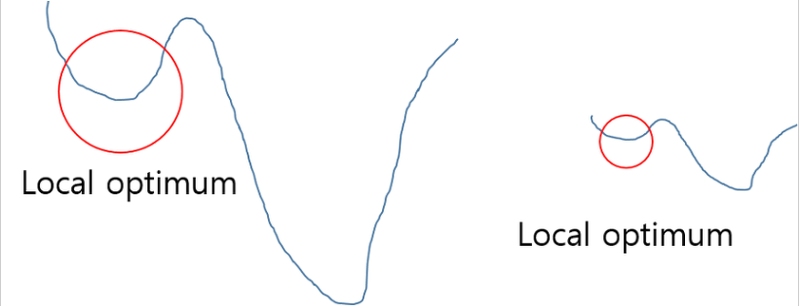

그림을 보면 왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다는 것을 직관적으로 이해할 수 있다.그리고 scikit-learn에서 MinMaxScaler로 쉽게 사용 할 수 있다.

In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, # 입력 이미지 정규화 및 크기 조정
        num_parallel_calls=1 # 병렬 처리
    )
    ds = ds.batch(batch_size) #배치 단위로 묶어주기
    if not is_test:
        ds = ds.repeat() # 데이터셋 반복 사용
        ds = ds.shuffle(200) # 데이터 섞어주기
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # 데이터 미리 로드하여 처리 속도 높이기
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

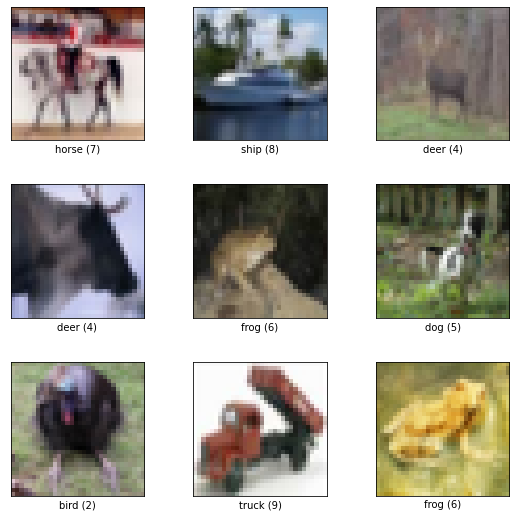

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

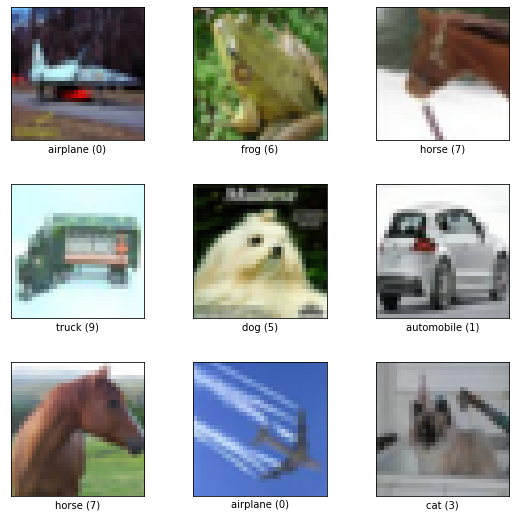

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

### Ablation Study 실습 (2) 블록 구성하기

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 **블록(block)** 이라고 부른다. **레이어(layer)** 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위이다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 한다.

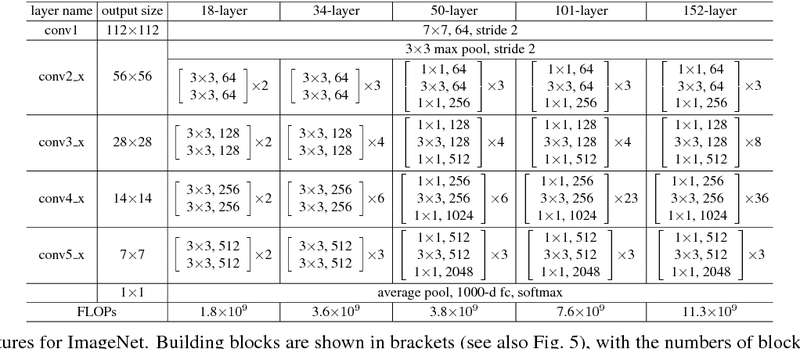

**ResNet**을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크

각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 된다. 따라서 이후 실습에서 우리는 ResNet의 기본 구조인 블록을 먼저 구현하자.

**VGG 기본 블록 만들기**

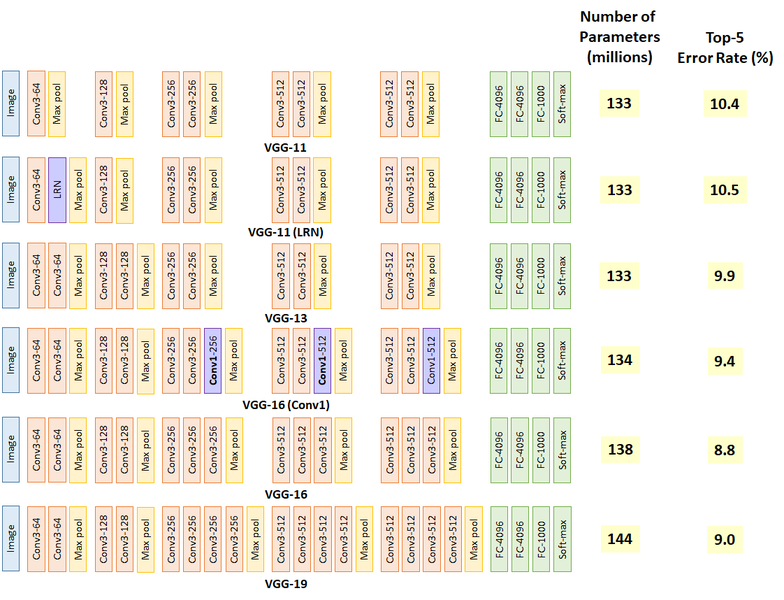

VGG는 여러 가지 버전이 있다. 이 중 VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해 보자.

블록을 구현하기 위해 모델 구조의 특징을 짚어보면,

VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어진다. CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있다. 그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다. 블록에 따라서 CNN 레이어의 개수 또한 달라진다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙는다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 한다.

block_num은 레이어의 이름을 붙여주기 위해서 추가되었고 input_shape는 summary를 출력하기 위해서 넣어주었다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### Ablation Study 실습 (3) VGG Complete Model

이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보자.

**1) VGG-16**

먼저 작은 네트워크인 VGG-16을 먼저 만들어 보자. 

블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 이는 VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달되어야 한다. 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달했다.

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

**2) VGG-19**

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [18]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
vgg_13 = build_vgg(
    num_cnn_list = [2,2,2,2,2],
    channel_list=[64,128,256,512,512]
)

vgg_13.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### Ablation Study 실습 (4) VGG-16 vs VGG-19

이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해서 모델을 훈련하고 평가하자.

VGG는 레이어의 차이를 위해서 VGG-16과 VGG-19를 비교해보도록 하자.

우선 CIFAR-10 데이터셋을 불러오자.

In [19]:
BATCH_SIZE = 256
EPOCH = 15

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

❗잠깐

이 작업은 시간이 상당히 소요된다다. BATCH_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있다만, 1epoch당 1분 이상 소요될 수도 있다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 15Epoch 정도로도 어느 정도 근접하는 성능을 얻을 수는 있을 것이다.

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 86s 143ms/step - loss: 2.1680 - accuracy: 0.1928 - val_loss: 2.0275 - val_accuracy: 0.2766
Epoch 2/15
195/195 [==============================] - 26s 133ms/step - loss: 1.9634 - accuracy: 0.2855 - val_loss: 1.8781 - val_accuracy: 0.3386
Epoch 3/15
195/195 [==============================] - 26s 134ms/step - loss: 1.8330 - accuracy: 0.3356 - val_loss: 1.8093 - val_accuracy: 0.3521
Epoch 4/15
195/195 [==============================] - 25s 131ms/step - loss: 1.7256 - accuracy: 0.3784 - val_loss: 1.6704 - val_accuracy: 0.3922
Epoch 5/15
195/195 [==============================] - 26s 133ms/step - loss: 1.6541 - accuracy: 0.4032 - val_loss: 1.6054 - val_accuracy: 0.4310
Epoch 6/15
195/195 [==============================] - 26s 133ms/step - loss: 1.5832 - accuracy: 0.4279 - val_loss: 1.5532 - val_accuracy: 0.4428
Epoch 7/15
195/195 [==============================] - 26s 133ms/step - loss: 1.5340 - accuracy: 0.4489 - val_loss: 1.4902 - val_ac

**steps_per_epoch** : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정

**validation_steps** : 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정

VGG-19 모델을 만들고 훈련시켜 주자.

파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸린다. Epoch 수나 BATCH_SIZE를 잘 조절하자.

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 36s 160ms/step - loss: 2.1818 - accuracy: 0.1860 - val_loss: 2.0882 - val_accuracy: 0.2264
Epoch 2/15
195/195 [==============================] - 30s 155ms/step - loss: 2.0023 - accuracy: 0.2671 - val_loss: 1.9268 - val_accuracy: 0.2983
Epoch 3/15
195/195 [==============================] - 30s 155ms/step - loss: 1.8872 - accuracy: 0.3191 - val_loss: 1.8435 - val_accuracy: 0.3610
Epoch 4/15
195/195 [==============================] - 30s 155ms/step - loss: 1.7682 - accuracy: 0.3629 - val_loss: 1.7543 - val_accuracy: 0.3793
Epoch 5/15
195/195 [==============================] - 30s 155ms/step - loss: 1.6859 - accuracy: 0.3904 - val_loss: 1.6413 - val_accuracy: 0.4163
Epoch 6/15
195/195 [==============================] - 30s 156ms/step - loss: 1.6132 - accuracy: 0.4186 - val_loss: 1.5613 - val_accuracy: 0.4315
Epoch 7/15
195/195 [==============================] - 30s 156ms/step - loss: 1.5577 - accuracy: 0.4394 - val_loss: 1.5181 - val_ac

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보자. 

먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해보자.

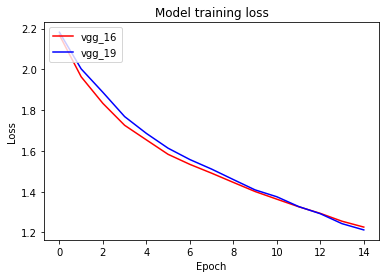

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

그리고 검증 정확도(validation accuracy)를 비교해 보자.

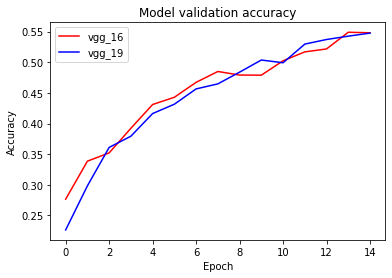

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()